# Решение обыкновенных дифференциальных уравнений (ОДУ)

Решатели ОДУ и их систем содержатся в пакете [`scipy.integrate`](https://docs.scipy.org/doc/scipy/tutorial/integrate.html).

## Задача

В качестве примера рассмотрим задачу построения траектории движения тела, брошенного под углом к горизонту, с учётом сопротивления воздуха. Данная задача аналитически без серьёзных допущений не решается.

## Математическая модель

Пусть шар массой $m$ брошен под углом $\alpha$ к горизонту из начала координат системы $Oxy$.
Коэффициент лобового сопротивления шара $c_{\rm drag}$.

Динамика полёта шара описывается векторным уравнением вида (2-ой закон Ньютона)

$$m \vec{\dot{v}} = - c_{\rm drag} \cfrac{\rho v^2}{2} S \cdot \cfrac{\vec v}{v} + m \vec{g},$$

где
$\vec{v}$ и $v$ - вектор скорости шара и её абсолютное значение соответственно;
$\rho$ - плотность воздуха;
$S$ - площадь сечения (миделя);
$\vec{g}$ - вектор ускорения свободного падения.
Знак "$-$" соответствует тому факту, что вектор силы лобового сопротивления противоположно направлен вектору скорости.
Направление вектора скорости задаётся единичным вектором $\vec{v} / v$.

Сократим $v$ в числителе и знаменателе и разделим обе части уравнения на $m$:

$$\vec{\dot{v}} = -\cfrac{c_{\rm drag} S \rho v}{2m} \cdot \vec{v} + \vec{g}.$$

Как известно, скорость - это производная координаты по времени: $\vec v = \vec{\dot r}$.
Здесь $\vec r = (x, y)^\mathrm{T}$ - радиус-вектор материальной точки (шара).

```{note}
Транспонирование означает лишь то, что мы работаем с векторами-столбцами.
**Транспонировать векторы в коде не нужно.**
```

Теперь наше ОДУ записывается так:

$$\vec{\ddot{r}} = -\cfrac{c_{\rm drag} S \rho v}{2m} \cdot \vec{\dot r} + \vec{g}.$$

Получили **ОДУ второго порядка**.

Часто используемые методы численного интегрирования не работают с векторными уравнениями и способны решать только ОДУ первого порядка.
Поэтому для численного интегрирования нам необходимо, _во-первых_, уйти от векторной формы записи ОДУ к скалярной и, _во-вторых_, свести уравнение второго порядка к системе уравнений первого порядка.

Запишем нашу систему в проекциях на оси СК, уйдя от векторной формы:

$$
\begin{cases}
    \ddot x = -\cfrac{c_{\rm drag} S \rho v}{2 m} \cdot \dot x + g_x, \\
    \ddot y = -\cfrac{c_{\rm drag} S \rho v}{2 m} \cdot \dot y + g_y.
\end{cases}
$$

Получили систему ОДУ 2-го порядка.
Теперь понизим порядок, учитывая, что $\dot x = v_x$ и $\dot y = v_y$:

$$
\begin{cases}
    \dot{v_x} = -\cfrac{c_{\rm drag} S \rho v}{2 m} \cdot v_x + g_x, \\
    \dot{v_y} = -\cfrac{c_{\rm drag} S \rho v}{2 m} \cdot v_y + g_y, \\
    \dot x = v_x, \\
    \dot y = v_y.
\end{cases}
$$ (eqn:fall)

Готово. Получена система ОДУ первого порядка:
в левых частях стоят только первые производные, а в правых - производные отсутствуют.

```{note}
Обратите внимание, что $v$ - это абсолютное значение вектора скорости $\vec v$, а $v_x$ и $v_y$ - значения составляющих этого вектора по осям $Oxy$, т.е. проекции на эти оси:
$v = \|\vec v\| = \sqrt{v_x^2 + v_y^2}$.
```

Пусть система координат (СК) $Oxy$ имеет горизонтальную ось $Ox$, направленную вправо, и вертикальну ось $Oy$, направленную вверх.
Тогда $\vec{g} = (0, -9.81)^\mathrm{T}$ м/с$^2$.

Для интегрирования необходимо задать начальные условия.
В данном случае это координаты и проекции скорости шара в начальный момент времени $t_0 = 0$.
Начальные координаты зададим напрямую: $x(0) = x_0$ и $y(0) = y_0$.
Вектор начальной скорости зададим через абсолютное значение $v_0 = v(0)$ и угол бросания $\alpha$:
$v_{x0} = v_0 \cos{\alpha}$ и $v_{y0} = v_0 \sin{\alpha}$.

Интегрируя уравнения {eq}`eqn:fall` при заданных начальных условиях, получим зависимости $v_x(t)$, $v_y(t)$, $x(t)$ и $y(t)$.
Траектория будет построена по массивам значений $x(t)$ и $y(t)$.

## Программная реализация

In [56]:
# 100% понадобится NumPy
import numpy as np

Проекция на вертикаль вектора ускорения свободного падения $g_y = -9.81$ м/с^2:

In [57]:
FREE_FALL = -9.81

Систему {eq}`eqn:fall` опишем в функции `ode_sys(t, y...)`:

In [58]:
def ode_sys(t, y, c_drag, air_dense, m, s_mid):
    # y[0] = v_x
    # y[1] = v_y
    # y[2] = x
    # y[3] = y
    # Абсолютная скорость
    v = np.sqrt(y[0]**2 + y[1]**2)
    # Вспомогательная переменная,
    # чтобы не считать одно и то же два раза
    coeff = 0.5 * c_drag * s_mid * air_dense * v / m
    return (
        -coeff * y[0],              # dv_x / dt
        -coeff * y[1] + FREE_FALL,  # dv_y / dt
        y[0],                       # dx / dt
        y[1]                        # dy / dt
    )

Первые два аргумента - время `t` и вектор значений переменных в этот момент `y` - обязательны и идут именно в таком порядке.
Последующие аргументы являются дополнительными.

Начальные условия.
Пусть $x_0 = 0$, $y_0 = 0$, $v_0 = 50$ м/с и $\alpha = 57.3\degree$,
откуда рассчитаем $v_{x0}$ и $v_{y0}$:

In [59]:
x0, y0 = 0., 0.
v0 = 50.
alpha = np.radians(53.7)
v_x0 = v0 * np.cos(alpha)
v_y0 = v0 * np.sin(alpha)
# Итоговый массив начальных условий
# в порядке записи уравнений для решателя
# (см. функцию ode_sys)
y0 = [v_x0, v_y0, x0, y0]

Также зададим остальные параметры задачи:

In [60]:
rho = 1.25      # Плотность воздуха, кг/м^3
c_drag = 1.     # Коэф-т лоб. сопротивления
m = 0.5         # Масса шара, кг
d = 0.1         # Диаметр шара, м
# Площадь миделя, м^2
S = 0.25 * np.pi * d**2

Интегрируем:

In [61]:
# Импортируем функцию решения задачи Коши
# (IVP - Initial Value Problem и есть задача Коши)
from scipy.integrate import solve_ivp

t_span = 0., 8.
sol = solve_ivp(
    ode_sys,
    t_span,
    y0,
    args=(c_drag, rho, m, S),
    dense_output=True
)

print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.828e-05  3.111e-04  3.139e-03  3.142e-02
             3.143e-01  1.170e+00  2.502e+00  4.737e+00  6.903e+00
             8.000e+00]
        y: [[ 2.960e+01  2.960e+01 ...  6.333e+00  4.664e+00]
            [ 4.030e+01  4.030e+01 ... -2.667e+01 -2.889e+01]
            [ 0.000e+00  8.372e-04 ...  9.737e+01  1.034e+02]
            [ 0.000e+00  1.140e-03 ... -2.441e+01 -5.499e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f1ccedc1ea0>
 t_events: None
 y_events: None
     nfev: 68
     njev: 0
      nlu: 0


Как видим функция [`solve_ivp(...)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) принимает на вход функцию, в которой описано ОДУ или система ОДУ, интервал интегрирования `t_span`, вектор начальных условий `y0`.
Поскольку наша `ode_sys` принимает дополнительные параметры, то мы перечисляем их в том же порядке в списке `args`.
Аргумент `dense_output` необходим для того, чтобы в экземпляре решения `sol` решатель сохранил функции интерполяции $v_x(t)$, $v_y(t)$, $x(t)$ и $y(t)$.
Тогда мы сможем получить вектор `y` в любой момент времени `t` в пределах `t_span` следующим образом: `sol.sol(t)`.

```{note}
По умолчанию `dense_output = False` и экземпляр решения (в данном случае `sol`) не имеет поля `sol`, т.е. `sol.sol(t)` вызовет ошибку.
```

Из результата следует, что в переменной `sol` содержатся массивы `t` и `y`, хранящие моменты времени и вектор значений интегрированных значений в эти моменты, а также др. служебную информацию.
Например, `nfenv` - число вызовов функции `ode_sys`.
Обратите внимание на то, что в выводе присутствует поле `sol`, имеющее тип `OdeSolution` - это и есть функция интерполяции решения, сохранённая благодаря `dense_output = True`.

Построим графики полученного решения:

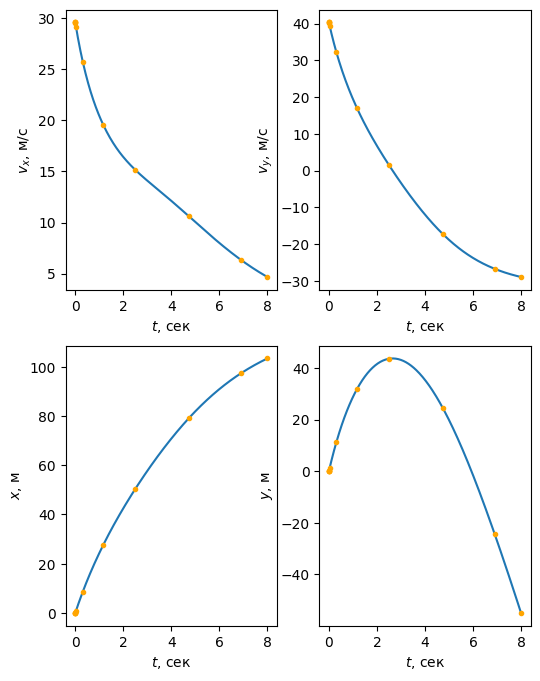

In [62]:
import matplotlib.pyplot as plt

# Разобьём интервал времени на любое число точек
t = np.linspace(*t_span, 300)
# Получим интерполированные значения для t
res = sol.sol(t)
# Распакуем результат по отдельным массивам
vx, vy = res[0], res[1]
x, y = res[2], res[3]

# Строим четыре графика
fig, ((ax_vx, ax_vy), (ax_x, ax_y)) = \
    plt.subplots(2, 2, figsize=(6, 8))

ax_vx.plot(t, vx)
# Расчётные точки
ax_vx.plot(sol.t, sol.y[0], ls="", c="orange", marker=".")
ax_vx.set(xlabel="$t$, сек", ylabel="$v_x$, м/с")

ax_x.plot(t, x)
# Расчётные точки
ax_x.plot(sol.t, sol.y[2], ls="", c="orange", marker=".")
ax_x.set(xlabel="$t$, сек", ylabel="$x$, м")

ax_vy.plot(t, vy)
# Расчётные точки
ax_vy.plot(sol.t, sol.y[1], ls="", c="orange", marker=".")
ax_vy.set(xlabel="$t$, сек", ylabel="$v_y$, м/с")

ax_y.plot(t, y)
# Расчётные точки
ax_y.plot(sol.t, sol.y[3], ls="", c="orange", marker=".")
ax_y.set(xlabel="$t$, сек", ylabel="$y$, м");

Траектория полёта:

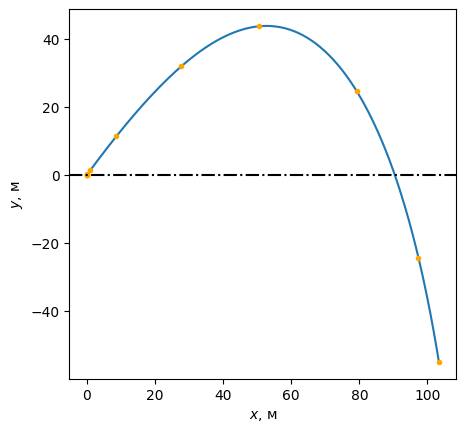

In [63]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(sol.y[2], sol.y[3], c="orange", ls="", marker=".")
ax.axhline(0, ls="-.", c="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");

Интервал времени велик, вследствие чего шар "проваливается" сквозь поверхность $y = 0$.
В SciPy предусмотрена возможность прерывания решения по заданному условию.
Для этого используется параметр `event` функции `solve_ivp`, посредством которого передаётся функция-условие, которую мы должны описать.

Функция-условие падения шара на землю ($y = 0$) описана ниже.
Она обязана принимать все те же параметры, что и функция системы ОДУ `ode_sys`.

In [64]:
# Поскольку здесь нам не нужны доп. аргументы
# c_drag, air_dense, m и s_mid, то мы просто используем
# синтаксис произвольного числа аргументов *args
def ev_fallen(t, y, *args):
    # Считается, что событие наступает тогда,
    # когда данная функция возвращает 0
    return y[3] # y-координата
    # Можно было бы написать и так:
    # return y[3] - 0
    # но это, очевидно, то же самое.
    # Тем не менее, вместо 0 мы можем написать 10,
    # и тогда событие наступит, когда шар будет
    # снизится до высоты 10 м.
# Далее укажем следующее:
#  - при выполнении условия решение должно прерваться:
ev_fallen.terminal = True
#  - направление изменения координаты -1:
#    с положительного на отрицательное
ev_fallen.direction = -1

Свойство направления перехода через значение `direction` позволяет обходить проблему, связанную с тем, что $y(0)$ у нас тоже равна $0$. Без указания направление прохода через $0$ решение прервалось бы в самом начале.

Снова проинтегрируем при том же `t_span`, но с условием `ev_fallen`:

In [65]:
sol = solve_ivp(
    ode_sys,
    t_span,
    y0,
    args=(c_drag, rho, m, S),
    dense_output=True,
    # Вот наше условие прерывания
    events=ev_fallen
)

print(sol)

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  2.828e-05  3.111e-04  3.139e-03  3.142e-02
             3.143e-01  1.170e+00  2.502e+00  4.737e+00  5.935e+00]
        y: [[ 2.960e+01  2.960e+01 ...  1.060e+01  8.125e+00]
            [ 4.030e+01  4.030e+01 ... -1.718e+01 -2.345e+01]
            [ 0.000e+00  8.372e-04 ...  7.920e+01  9.038e+01]
            [ 0.000e+00  1.140e-03 ...  2.458e+01  3.553e-15]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f1ccefefbb0>
 t_events: [array([ 5.935e+00])]
 y_events: [array([[ 8.125e+00, -2.345e+01,  9.038e+01,  3.553e-15]])]
     nfev: 62
     njev: 0
      nlu: 0


Изменился статус решения - оно было прервано событием.
Кроме того, появилось ещё два поля: `t_events` и `y_events`, хранящие момент времени наступления события и вектор решения в этот момент.

Теперь посмотрим на траекторию:

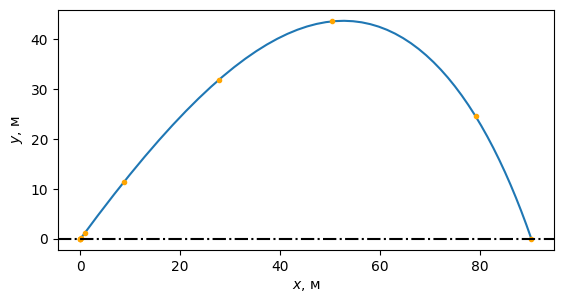

In [66]:
# Теперь при формировании массива t используем
# время наступления события падения шара на поверхность
# (приходится использовать два индекса из-за того,
# как решатель сохраняет t_events)
t = np.linspace(t_span[0], sol.t_events[-1][0])
res = sol.sol(t)
x, y = res[2], res[3]

fig, ax = plt.subplots()
ax.plot(x, y)
# Покажем точки решения
ax.plot(sol.y[2], sol.y[3], c="orange", ls="", marker=".")
ax.axhline(0, ls="-.", c="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");

Если для события `terminal = False` (по умолчанию это так), то после его наступления решение продолжится до конца интервала интегрирования.
По умолчанию `direction = 0`, что соответствует переходу значения в любом направлении (с $+$ на $-$ или с $-$ на $+$).
Функции-условия могут иметь сколь угодно сложный вид.

## Заключение

1. Функции решения систем ОДУ содержатся в модуле [`scipy.integrate`](https://docs.scipy.org/doc/scipy/tutorial/integrate.html).
2. Для численного интегрирования системы ОДУ необходимо привести её к первому порядку в скалярном виде.
3. Необходимо задать начальные условия для решения задачи Коши и интервал интегрирования `t_span` в том же порядке, что описан в функции, реализующей систему ОДУ.
4. Параметр `dense_output` отвечает за сохранение в функций, интерполирующих результаты решения.
5. Функции, переданные через `events`, позволяют сохранять метки времени `t_events` и решения в эти моменты `y_events` при заданных условиях. При необходимости можно прерывать интегрирование при наступлении событий. Сигнатуры функции, описывающей систему ОДУ, и функции-события должны совпадать.

## См. также

1. `solve_ivp(...)` имеет параметр `method`, через который можно задать метод интегрирования, коих существует [множество](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). По умолчанию используется метод Рунге-Кутты четвёртого-пятого порядка (`RK45`).
2. Метод [LSODA](https://rdrr.io/cran/deSolve/man/lsoda.html) подходит для решения [жёстких систем ОДУ](https://ru.wikipedia.org/wiki/Жёсткая_система).
3. Для решения [краевых задач](https://ru.wikipedia.org/wiki/Краевая_задача) имеется функция [`solve_bvp(...)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html) (BVP - Boundary Value Problem).